In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
%matplotlib inline

import seaborn as sns

In [2]:
df = pd.read_csv('raw_data.csv')

In [3]:
# Берём только "валидные" точки, и фильтруем выбросы (нулевые координаты)
df_valid = df[(df['valid'] == True) & (df['lat'] > 0.0) & (df['lon'] > 0.0)]
# Разделяем dataset по значению operator_id
df1 = df_valid[df_valid['opid'] == 1001]
df2 = df_valid[df_valid['opid'] == 1002]
# Список ТС операторов 1 и 2
operator1_vehicles = df1.groupby('oid').count().index.tolist()
operator2_vehicles = df2.groupby('oid').count().index.tolist()

In [4]:
# находим ускорение по изменению скорости
def get_acceleration_axis(operator_id, vehicle_id, axis):
    if (operator_id == 1001):
        df_device = df1[df1['oid'] == vehicle_id].sort_values(by=['ntm'])
    if (operator_id == 1002):
        df_device = df2[df2['oid'] == vehicle_id].sort_values(by=['ntm'])
    
    w = df_device['spd'].as_matrix() * (10.0 / 36.0)        # переводим в м/с
    dir = df_device['dir'].as_matrix() * (math.pi / 180.0)  # азимут в радианах
    
    if axis == 'x':
        w_axis = w * np.sin(dir)
    if axis == 'y':
        w_axis = w * np.cos(dir)
    
    delta_w = np.diff(w_axis, axis=0) 
    delta_time = np.diff(df_device['ntm'].as_matrix()/1000.0, axis=0)  # переводим в с
    
    acc_axis = delta_w / delta_time
    
    return acc_axis

In [5]:
# находим модуль ускорения (по компонентам x и y)
def get_acceleration_abs(operator_id, vehicle_id):
    if (operator_id == 1001):
        df_device = df1[df1['oid'] == vehicle_id].sort_values(by=['ntm'])
    if (operator_id == 1002):
        df_device = df2[df2['oid'] == vehicle_id].sort_values(by=['ntm'])
    
    w = df_device['spd'].as_matrix() * (10.0 / 36.0)        # переводим в м/с
    dir = df_device['dir'].as_matrix() * (math.pi / 180.0)  # азимут в радианах
    wx = w * np.sin(dir)
    wy = w * np.cos(dir)
    
    delta_wx = np.diff(wx, axis=0) 
    delta_wy = np.diff(wy, axis=0)
    delta_time = np.diff(df_device['ntm'].as_matrix()/1000.0, axis=0)  # переводим в с
    
    acc_x = delta_wx / delta_time
    acc_y = delta_wy / delta_time
    
    acc = np.sqrt(acc_x**2 + acc_y**2)
    
    return acc

In [6]:
# находим ускорение по изменению скорости
def get_acceleration(operator_id, vehicle_id):
    if operator_id == 1001:
        df_device = df1[df1['oid'] == vehicle_id].sort_values(by=['ntm'])
    if operator_id == 1002:
        df_device = df2[df2['oid'] == vehicle_id].sort_values(by=['ntm'])
    
    w = df_device['spd'].as_matrix() * (10.0 / 36.0)        # переводим в м/с
    
    delta_w = np.diff(w, axis=0) 
    delta_time = np.diff(df_device['ntm'].as_matrix()/1000.0, axis=0)  # переводим в с
    
    acc = delta_w / delta_time
    
    return acc

In [7]:
# Оценим ускорение для машин
acceleration_all_x = np.empty((0,))
acceleration_all_y = np.empty((0,))

for vehicle in operator1_vehicles:
    acceleration_x = get_acceleration_axis(1001, vehicle, 'x')
    acceleration_y = get_acceleration_axis(1001, vehicle, 'y') 
    acceleration_all_x = np.hstack([acceleration_all_x, acceleration_x])
    acceleration_all_y = np.hstack([acceleration_all_y, acceleration_y])
    
for vehicle in operator2_vehicles:
    acceleration_x = get_acceleration_axis(1002, vehicle, 'x')
    acceleration_y = get_acceleration_axis(1002, vehicle, 'y') 
    acceleration_all_x = np.hstack([acceleration_all_x, acceleration_x])
    acceleration_all_y = np.hstack([acceleration_all_y, acceleration_y])

print("---------- Ускорение по оси X ----------")
print("Размерность массива ускорений = %s" % acceleration_all_x.shape)
print("Mean = %f" % acceleration_all_x.mean()) # среднее значение
print("Min = %f" % acceleration_all_x.min())  # минимум
print("Max = %f" % acceleration_all_x.max())  # максимум
print("Среднеквадратическое отклонение = %f" % acceleration_all_x.std())  # среднеквадратическое отклонение
print("Дисперсия = %f" % acceleration_all_x.var())  # дисперсия

print("---------- Ускорение по оси Y ----------")
print("Размерность массива ускорений = %s" % acceleration_all_y.shape)
print("Mean = %f" % acceleration_all_y.mean()) # среднее значение
print("Min = %f" % acceleration_all_y.min())  # минимум
print("Max = %f" % acceleration_all_y.max())  # максимум
print("Среднеквадратическое отклонение = %f" % acceleration_all_y.std())  # среднеквадратическое отклонение
print("Дисперсия = %f" % acceleration_all_y.var())  # дисперсия

---------- Ускорение по оси X ----------
Размерность массива ускорений = 1282201
Mean = 0.000543
Min = -25.013519
Max = 11.458266
Среднеквадратическое отклонение = 0.542965
Дисперсия = 0.294811
---------- Ускорение по оси Y ----------
Размерность массива ускорений = 1282201
Mean = 0.000071
Min = -10.535348
Max = 15.030127
Среднеквадратическое отклонение = 0.551736
Дисперсия = 0.304412


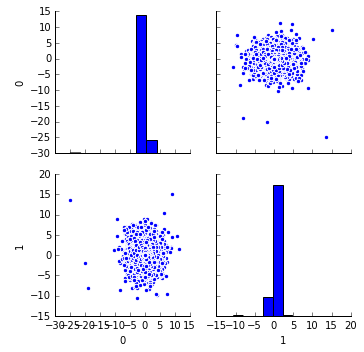

In [8]:
acc_array = np.column_stack((acceleration_all_x, acceleration_all_y))
acc = pd.DataFrame(acc_array)
sns_plot = sns.pairplot(acc)

In [9]:
# Находим ковариацию (ковариационную матрицу) между ускорениями по оси X и Y
np.cov(np.vstack((acceleration_all_x, acceleration_all_y)))

array([[ 0.29481169,  0.00273116],
       [ 0.00273116,  0.30441248]])

In [13]:
acc.cov()

,0,1
0,0.294812,0.002731
1,0.002731,0.304412


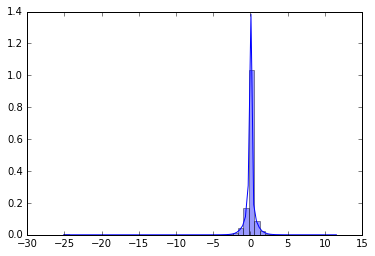

In [10]:
sns.distplot(acceleration_all_x)

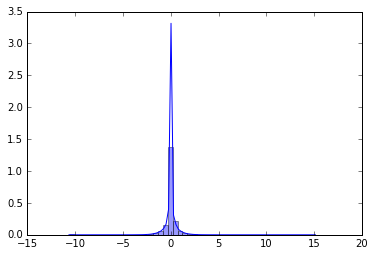

In [11]:
sns.distplot(acceleration_all_y)